In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

from utils import *
from AnalyseDefects import AnalyseDefects

In [66]:
def gen_analysis_dict(LL, mode):

    dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
    dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
                suffix = "long", priority = 1, LX = LL, Nframes = 400)
    priority_vl = 2 if LL == 512 else 3
    dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                    suffix = "very_long", priority = priority_vl, LX = LL, Nframes = 1500)
    dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_v2',\
                    suffix = "very_long2", priority = 3 if priority_vl == 2 else 2, LX = LL, Nframes = 1500)

    if mode == 'all':
        if LL == 2048:
            defect_list = [dshort, dlong]
        else:
            defect_list = [dshort, dlong, dvery_long, dvery_long2] if LL in [256, 512] else [dshort, dlong, dvery_long]
    else:
        defect_list = [dshort]
    
    return defect_list

In [80]:
LL = 2048
output_path = f'data\\nematic_analysis{LL}_LL0.05'
mode = 'all' # 'all' or 'short'

defect_list = gen_analysis_dict(LL, mode)

ad = AnalyseDefects(defect_list, output_path=output_path)

extract = False
analyze = False
merge = False


In [81]:
ad.extract_results()

Analyse defects for input folder C:\Users\Simon Andersen\Documents\Uni\Speciale\Hyperuniformity\nematic_analysis2048_LL0.05
Analyse defects for input folder C:\Users\Simon Andersen\Documents\Uni\Speciale\Hyperuniformity\nematic_analysis2048_LL0.05_long


In [83]:
ad.analyze_defects()

NB: All simulations are set to converge at the first frame for dataset 0. To change this, call update_conv_list.



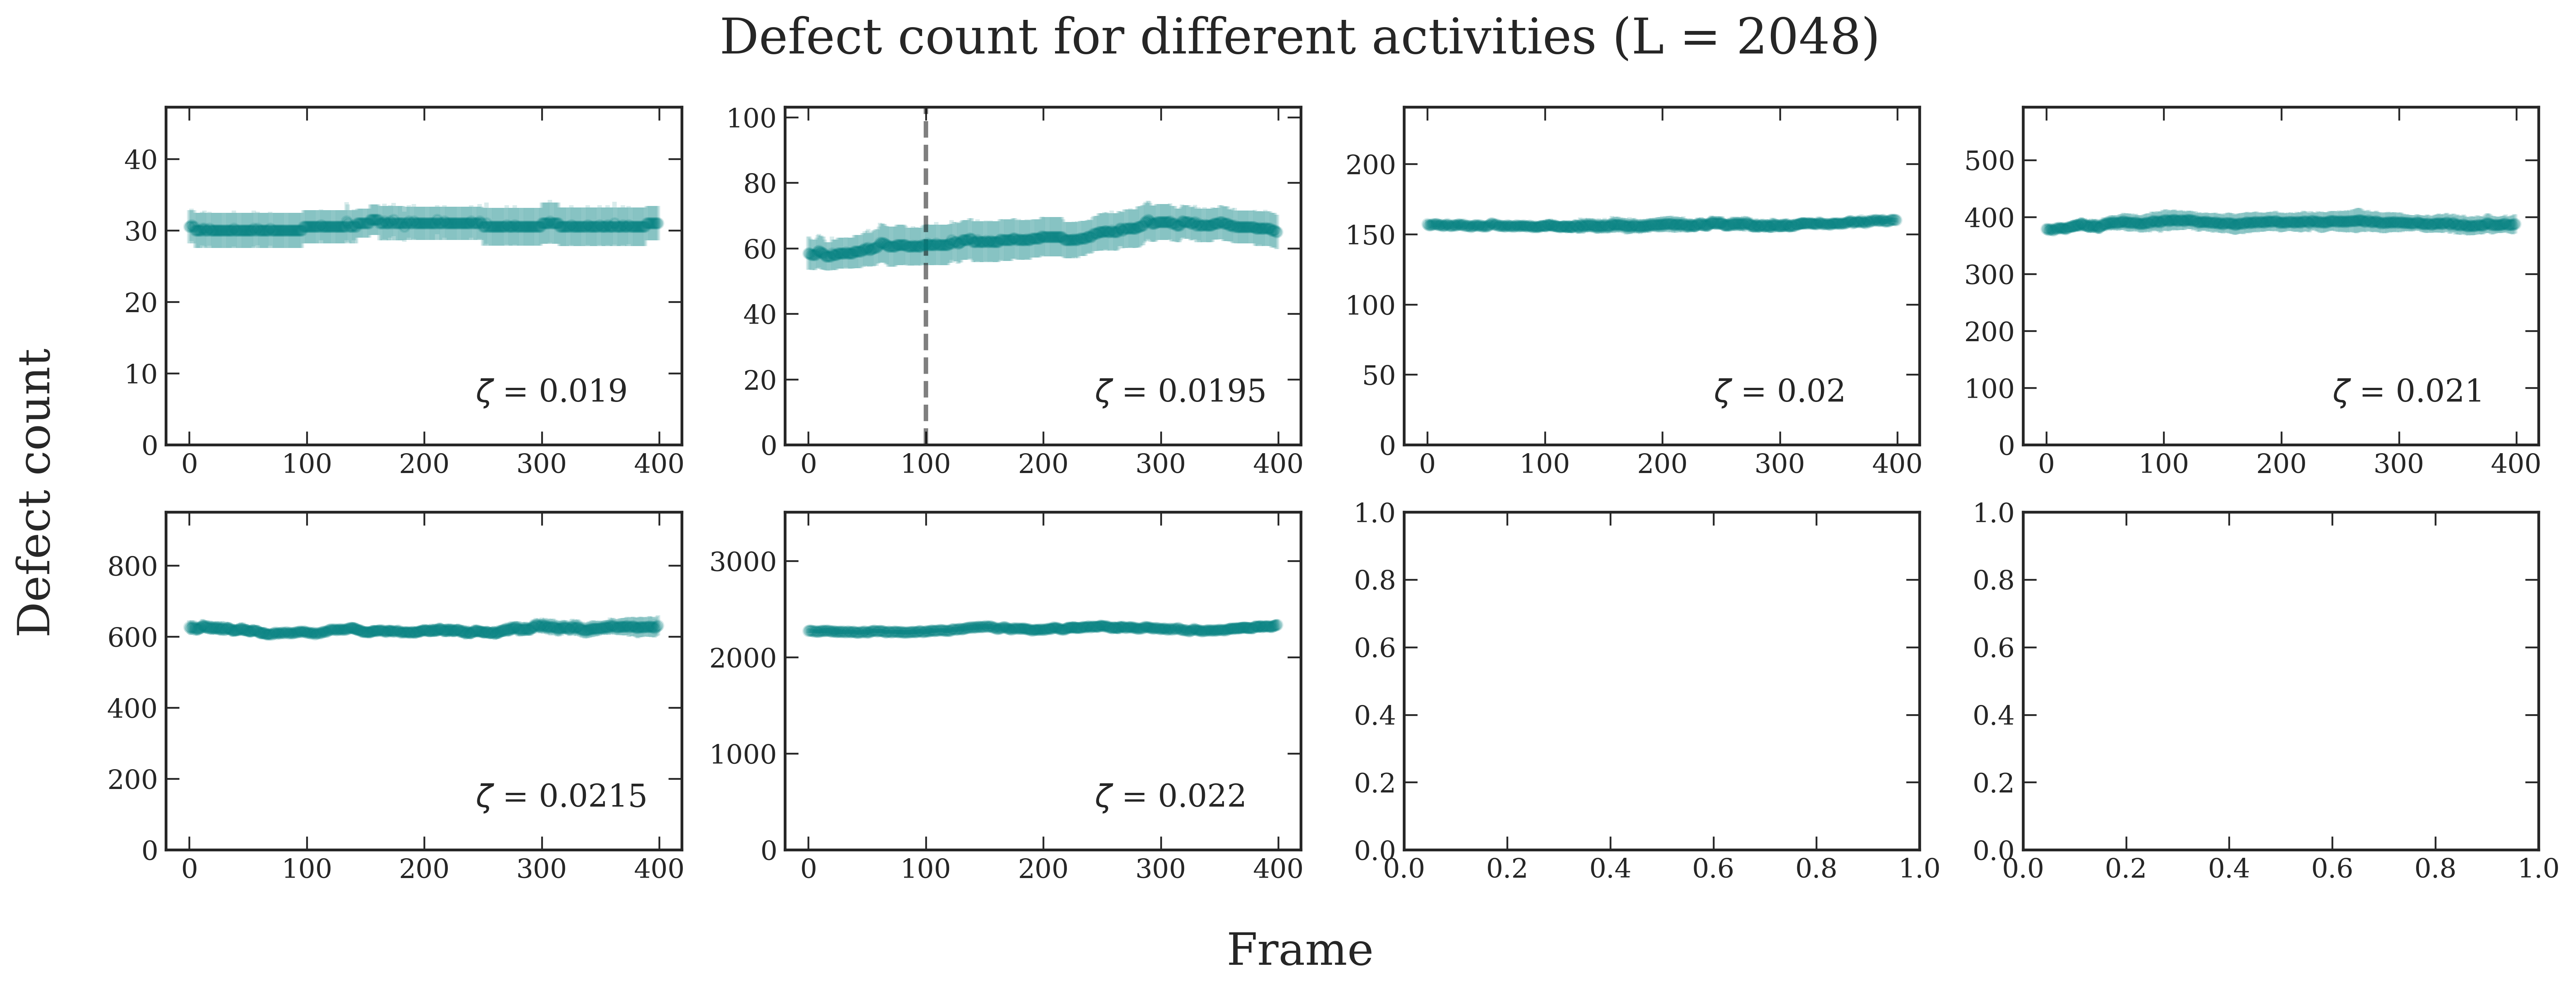

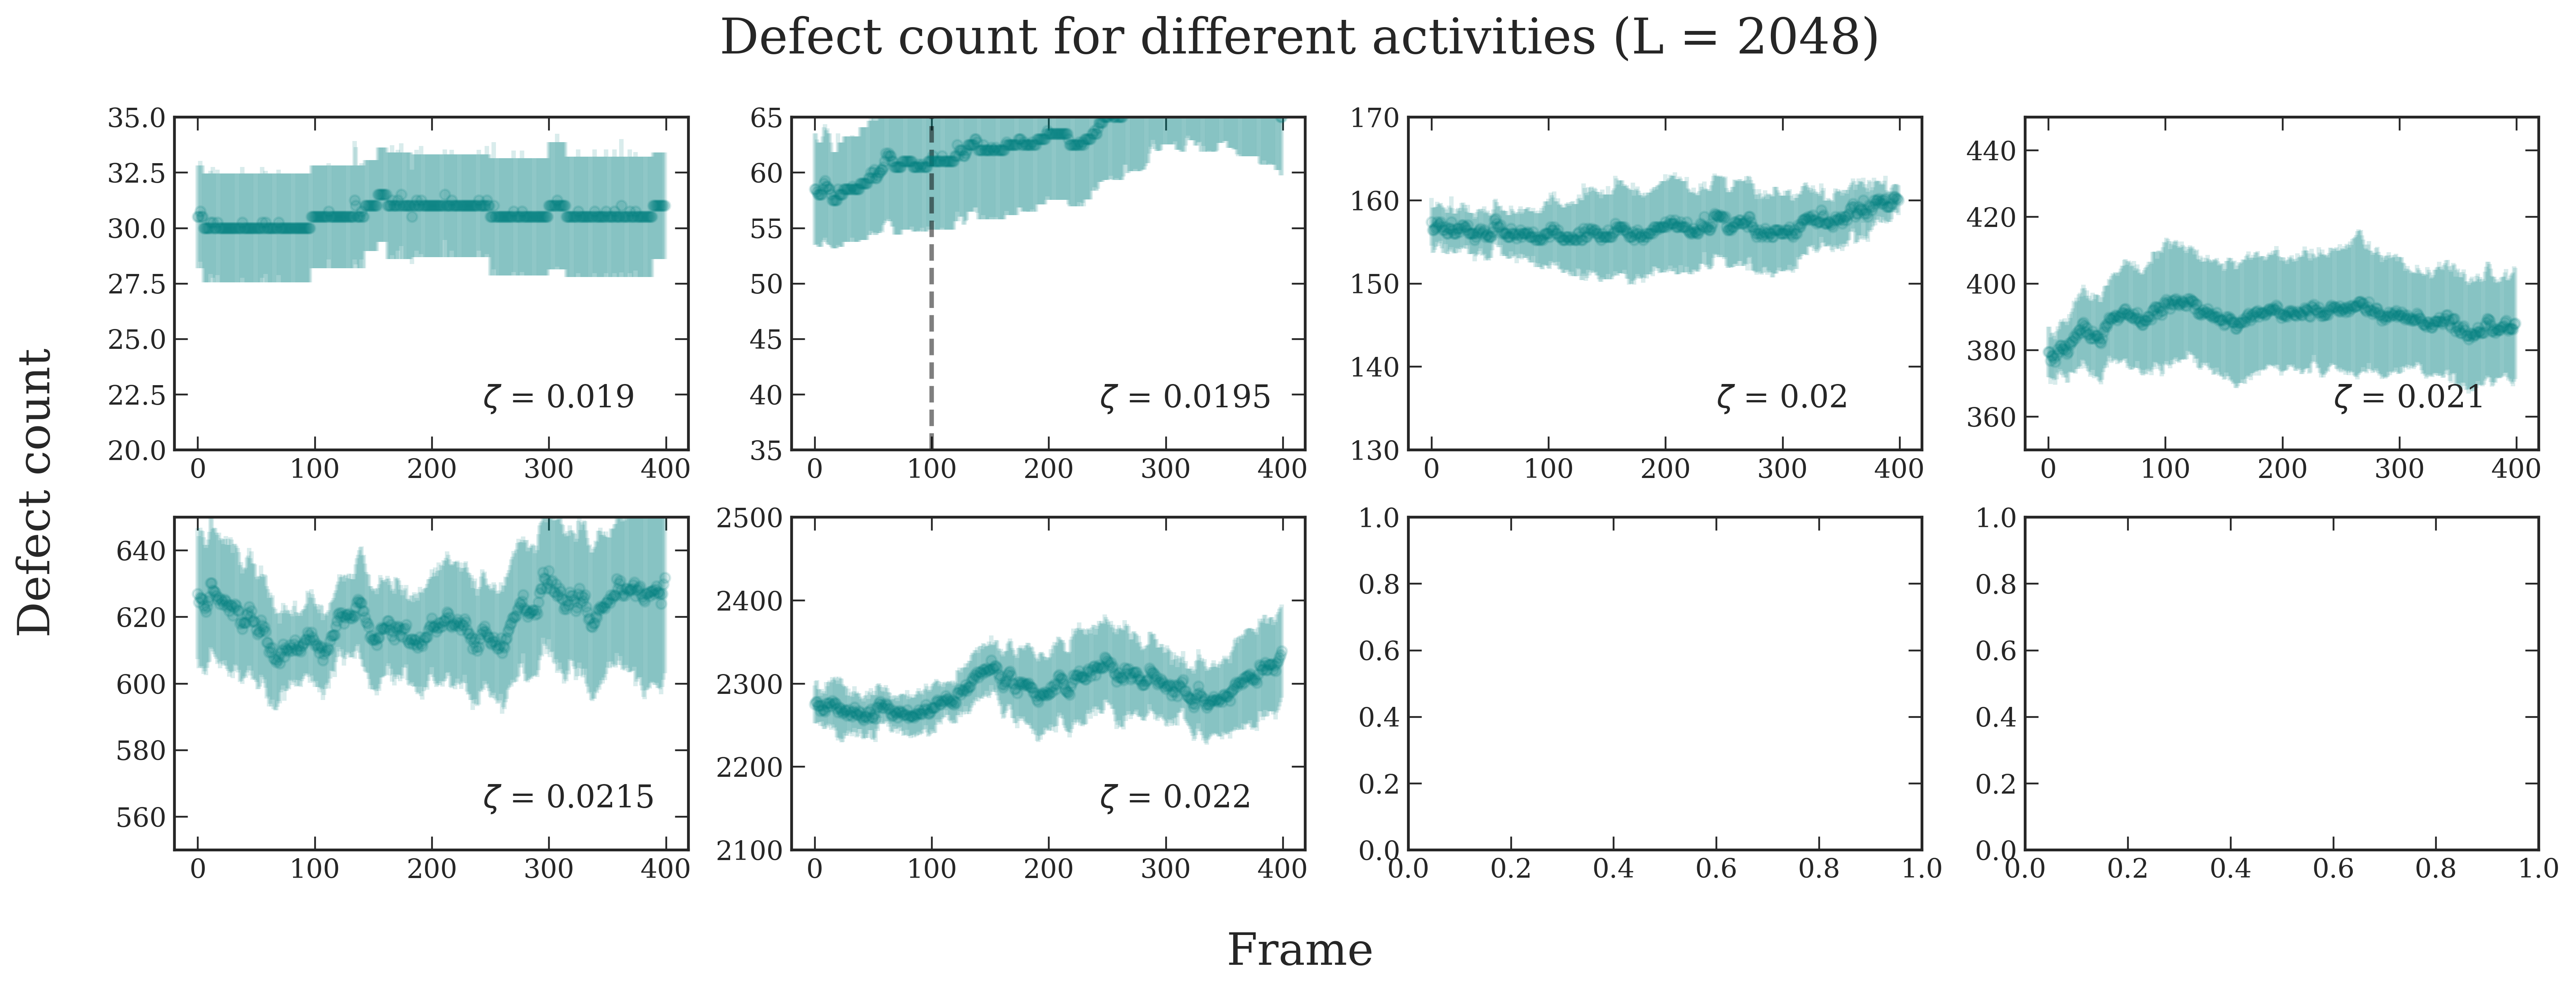

In [84]:
fig, ax = ad.plot_defects_per_activity(Ndataset=1);
ylims=[(20,35),(35,65),(130,170),(350,450),(550,650),(2100,2500)]
for i in range(6):
    ax[i].set_ylim(ylims[i])
fig

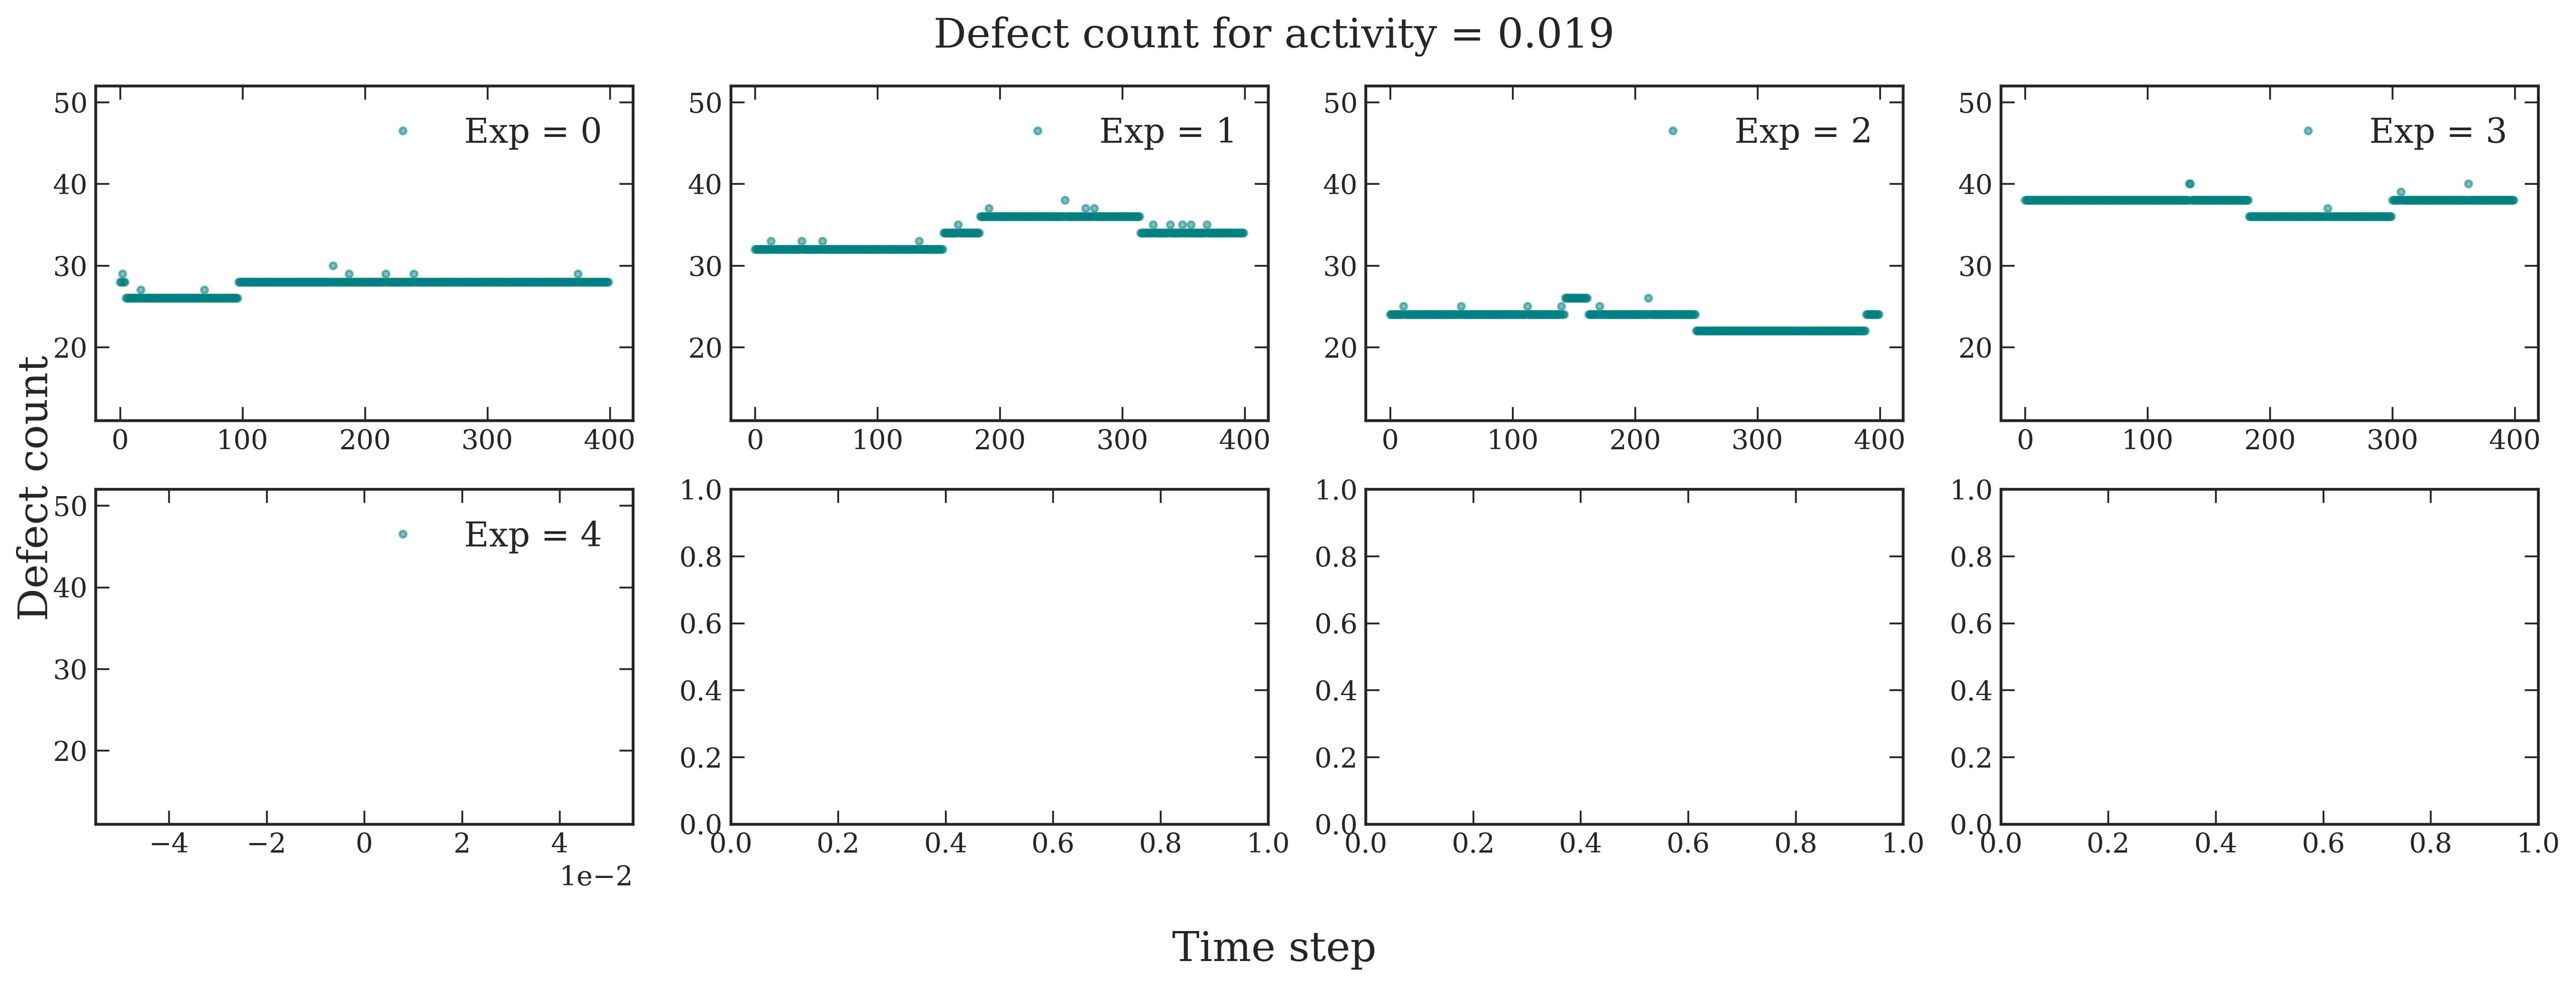

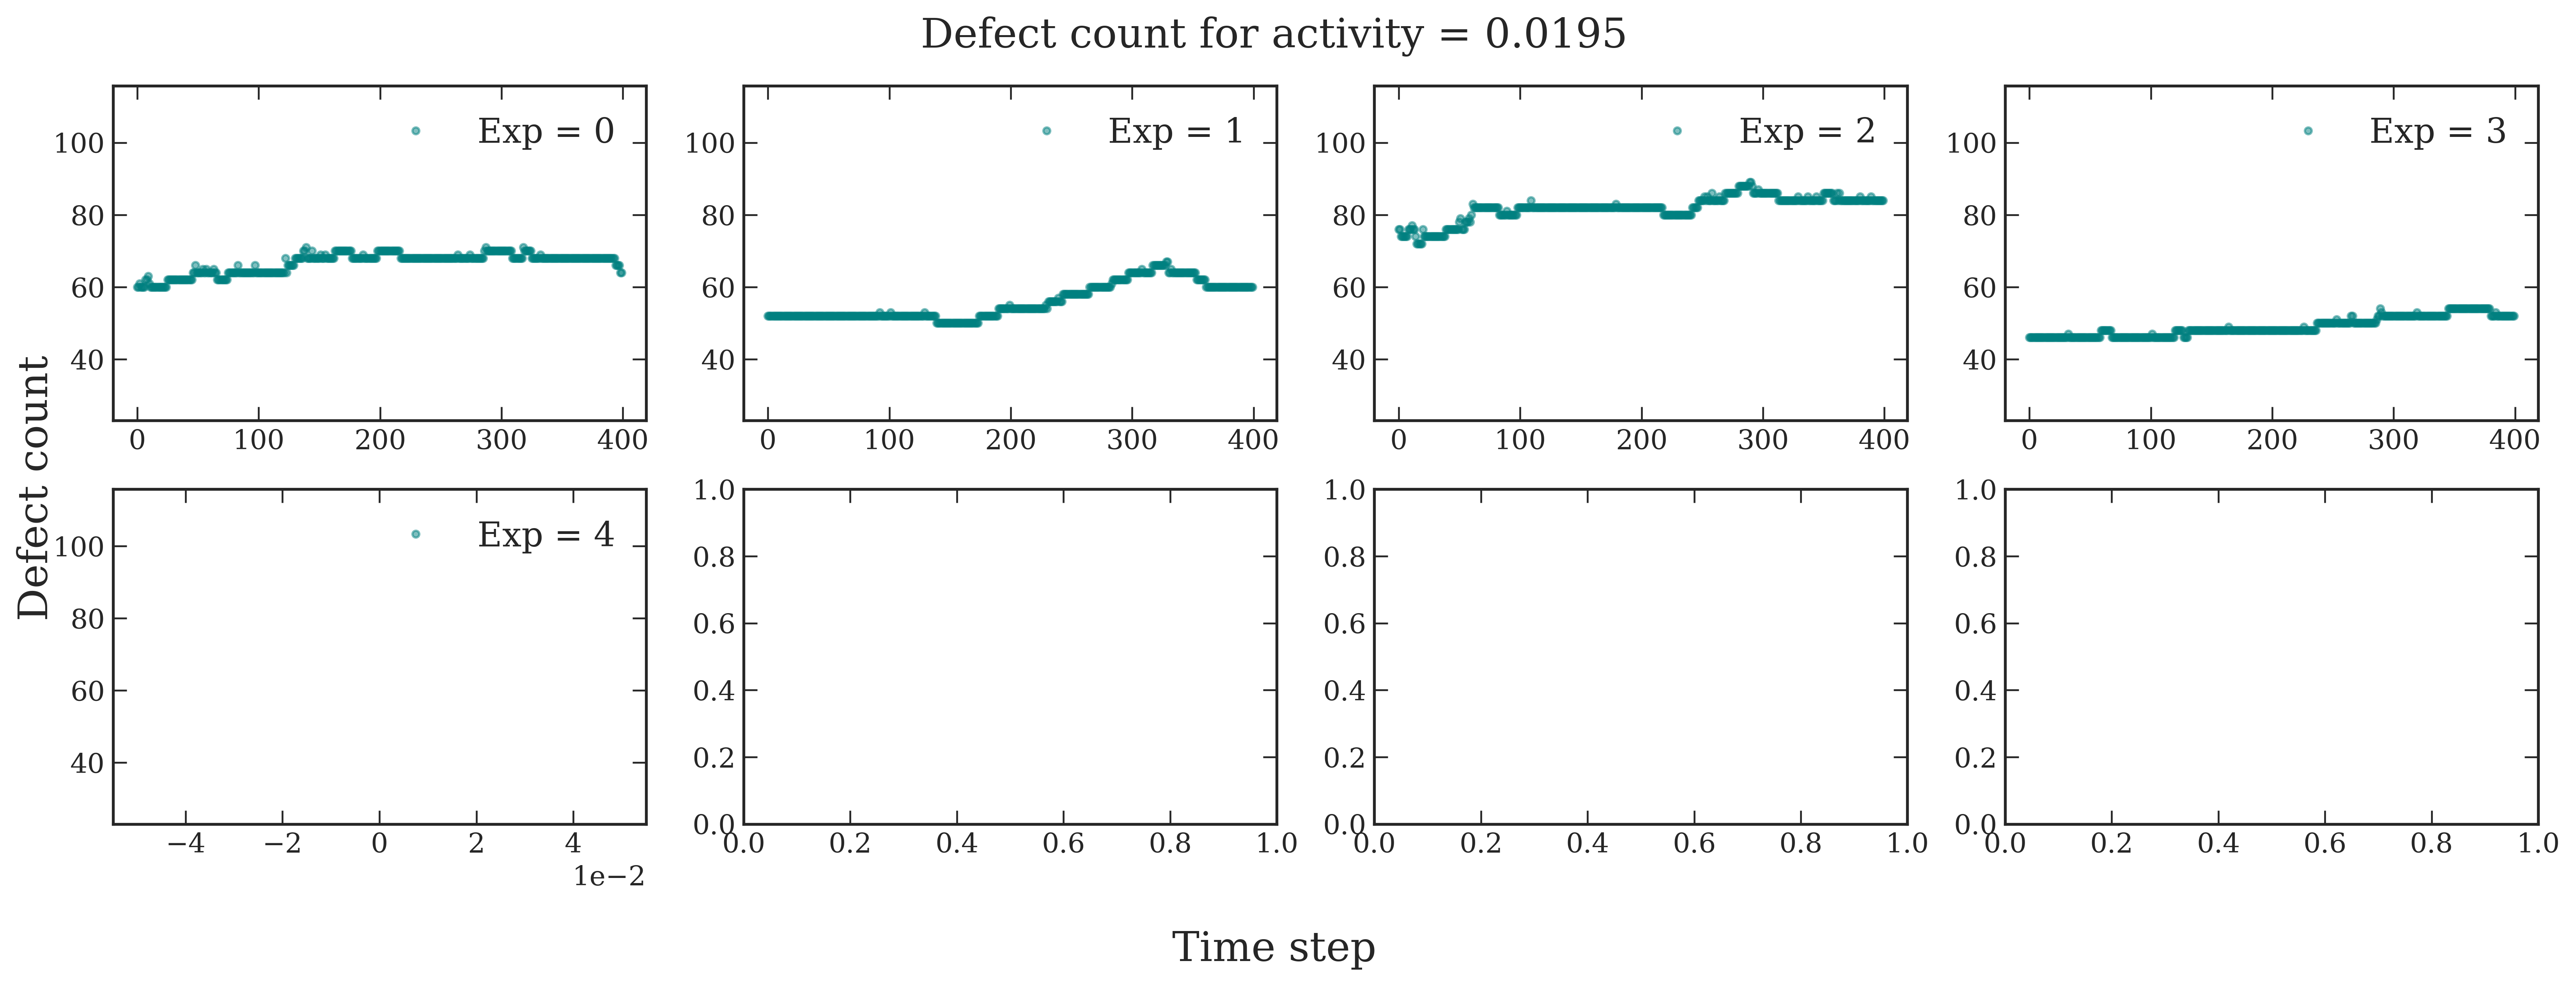

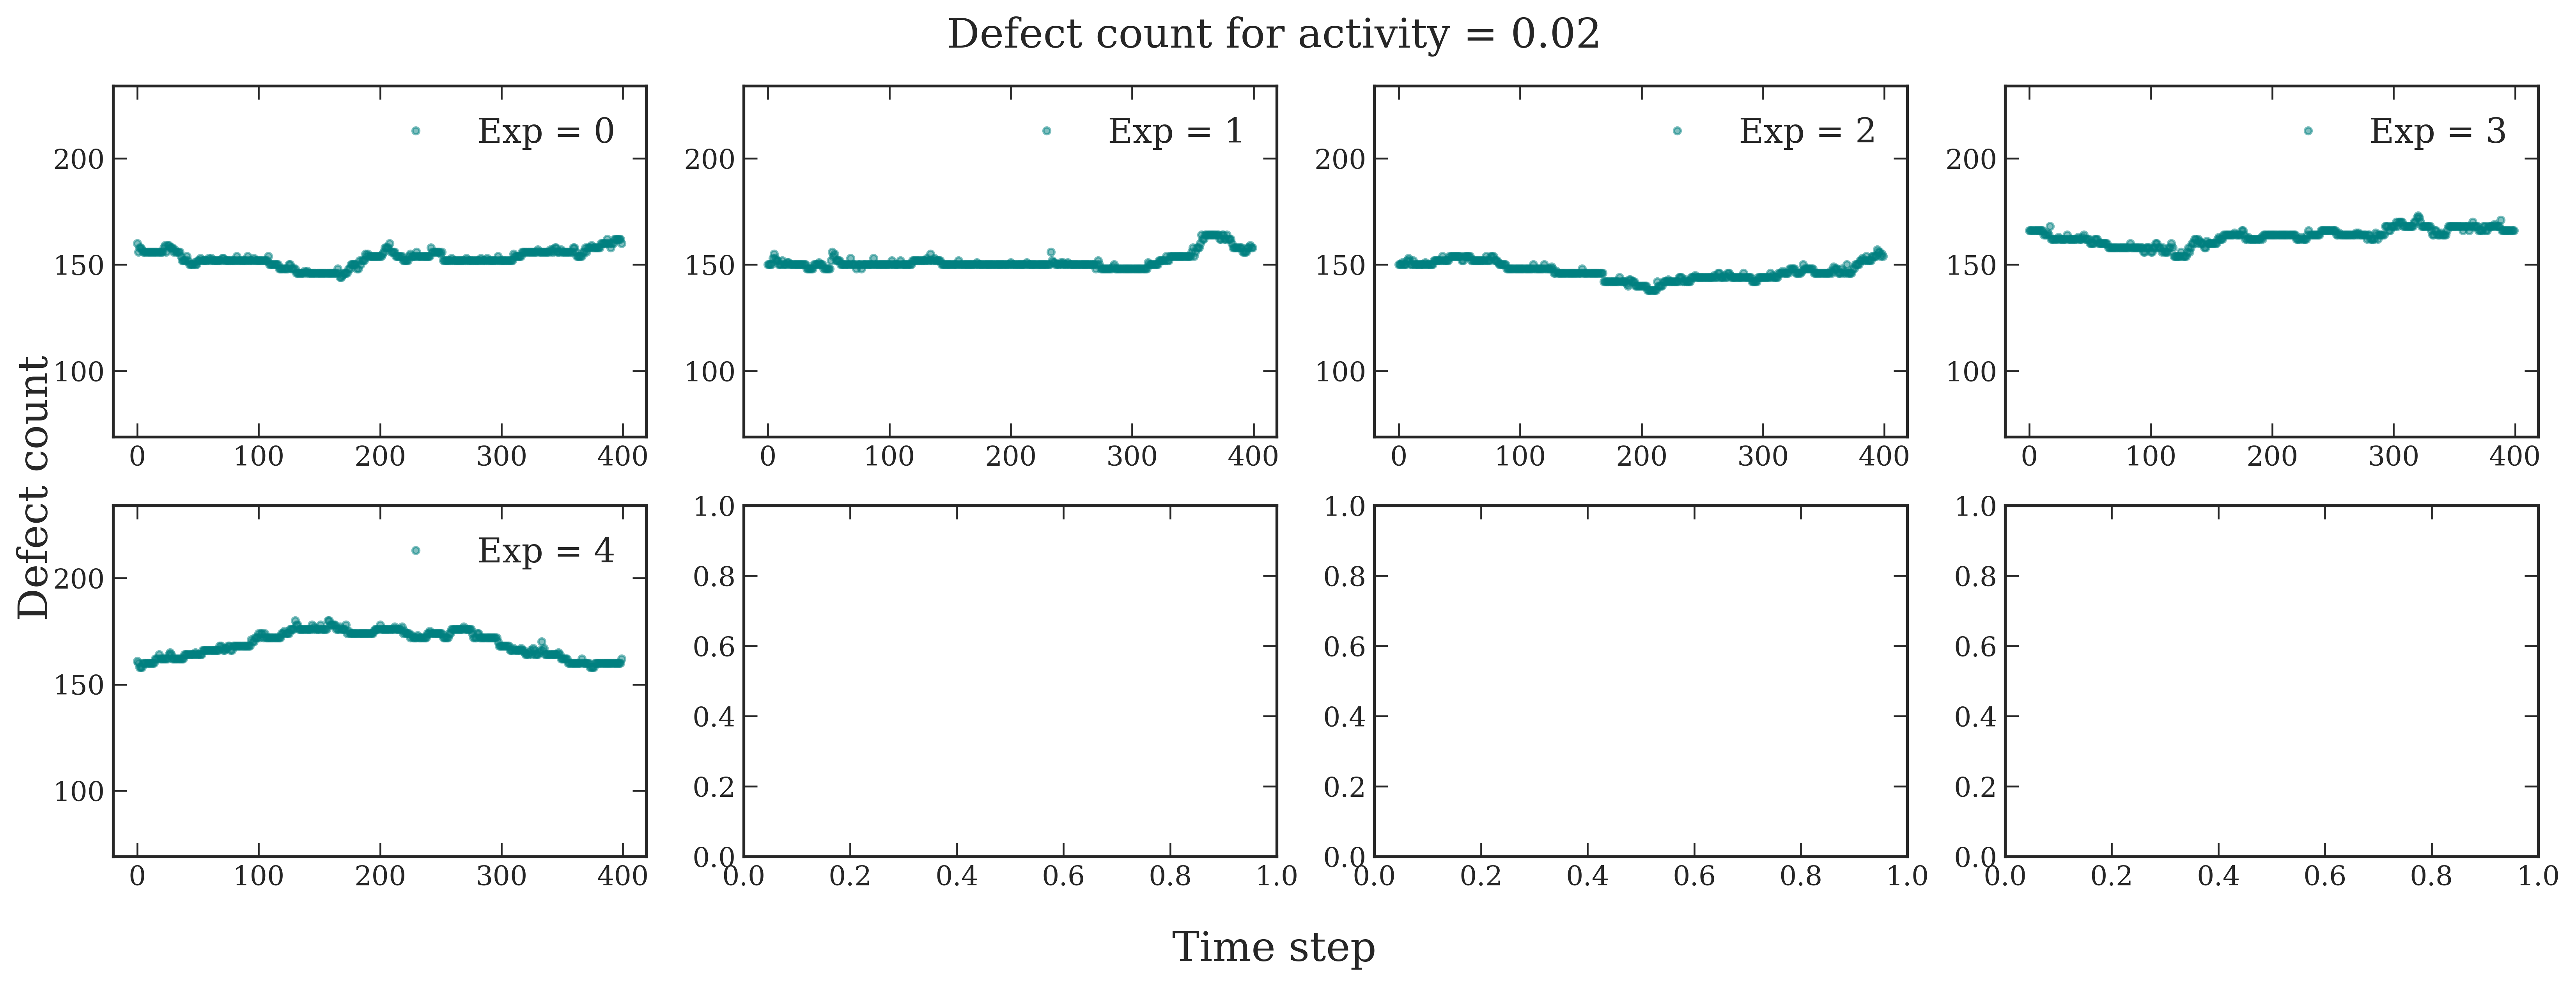

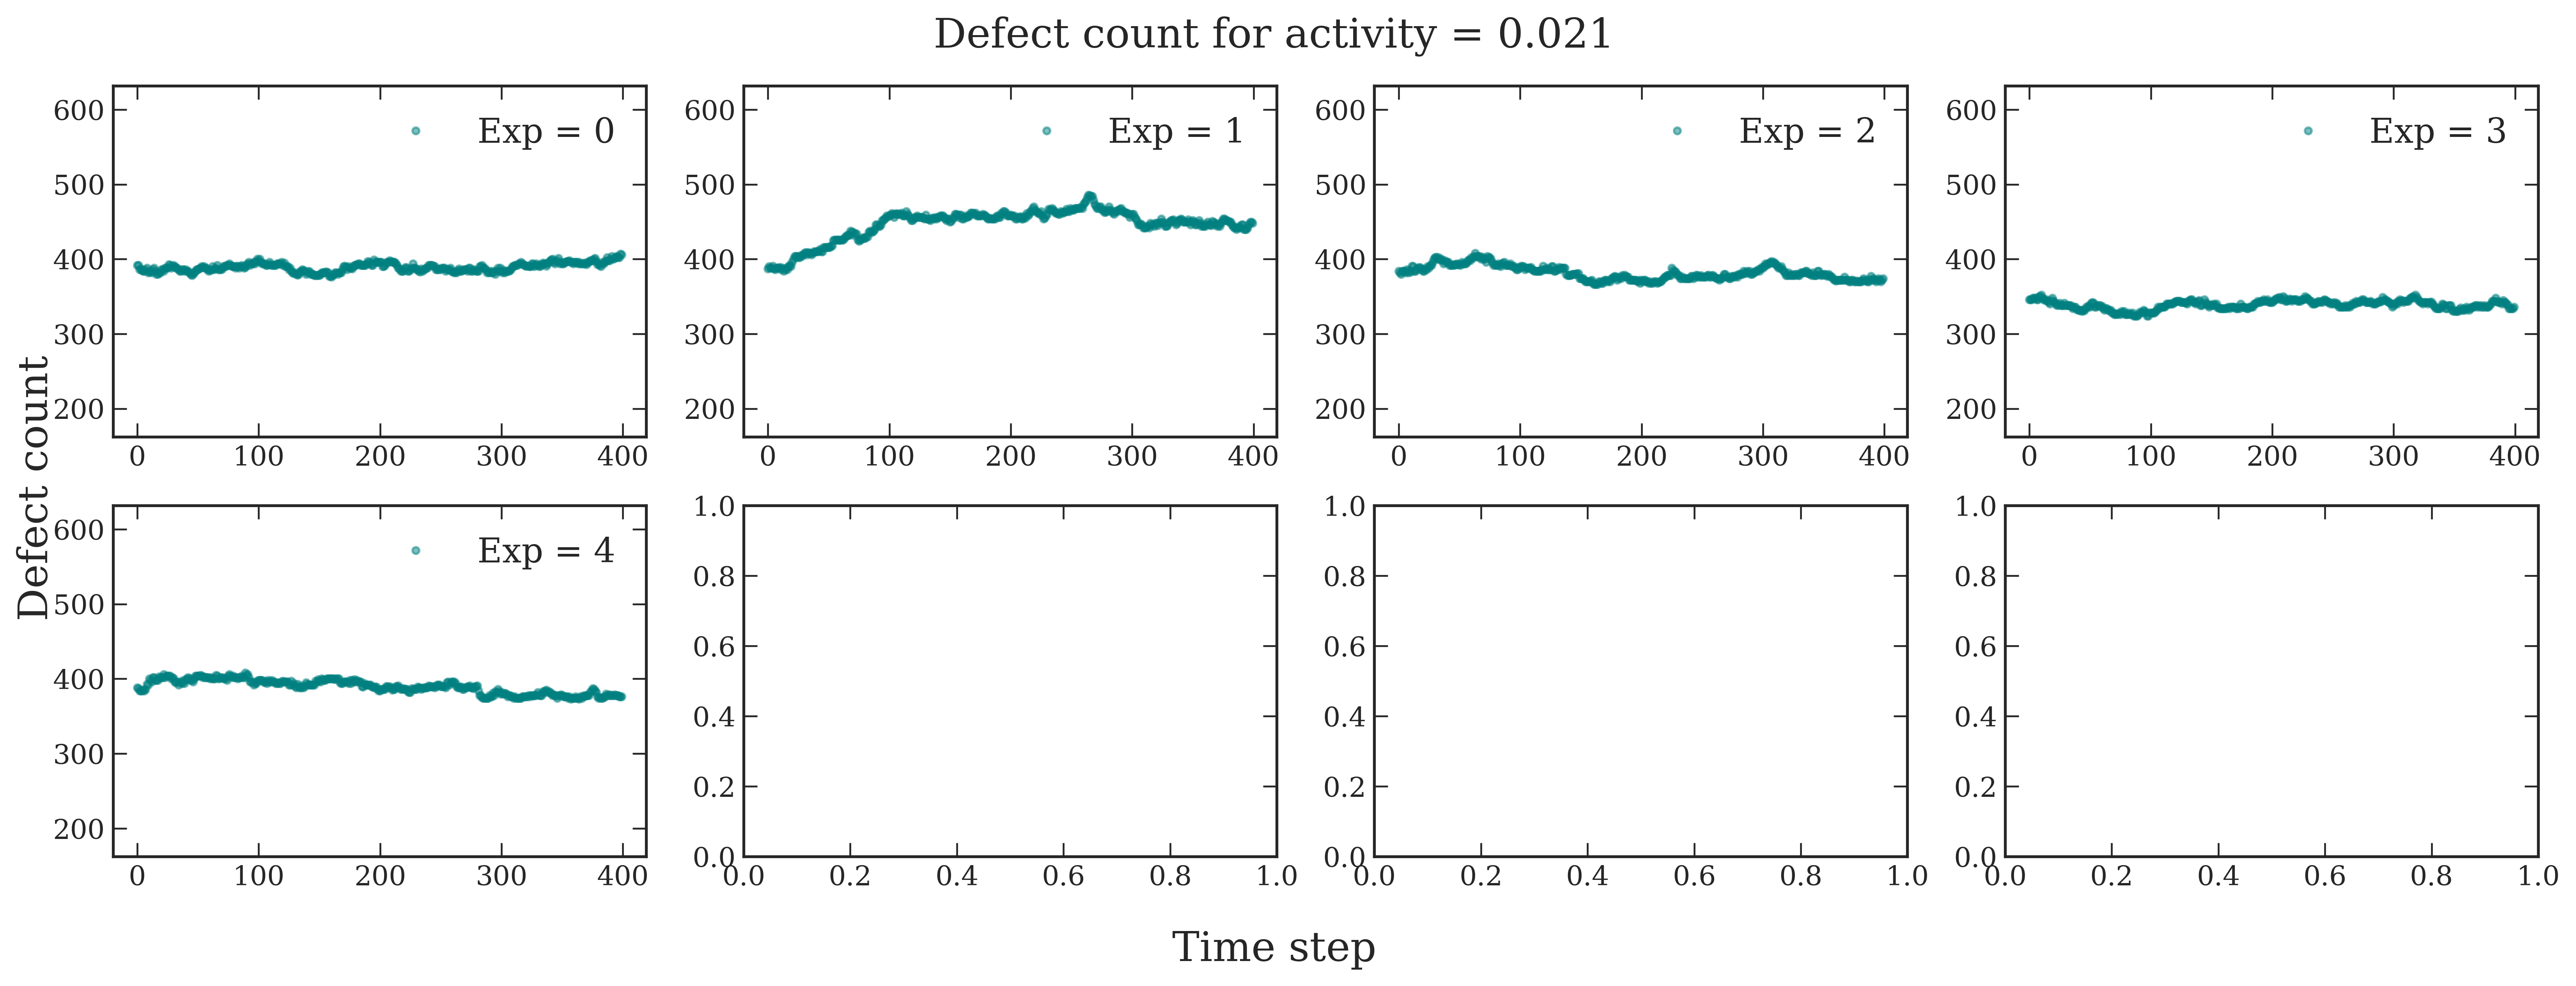

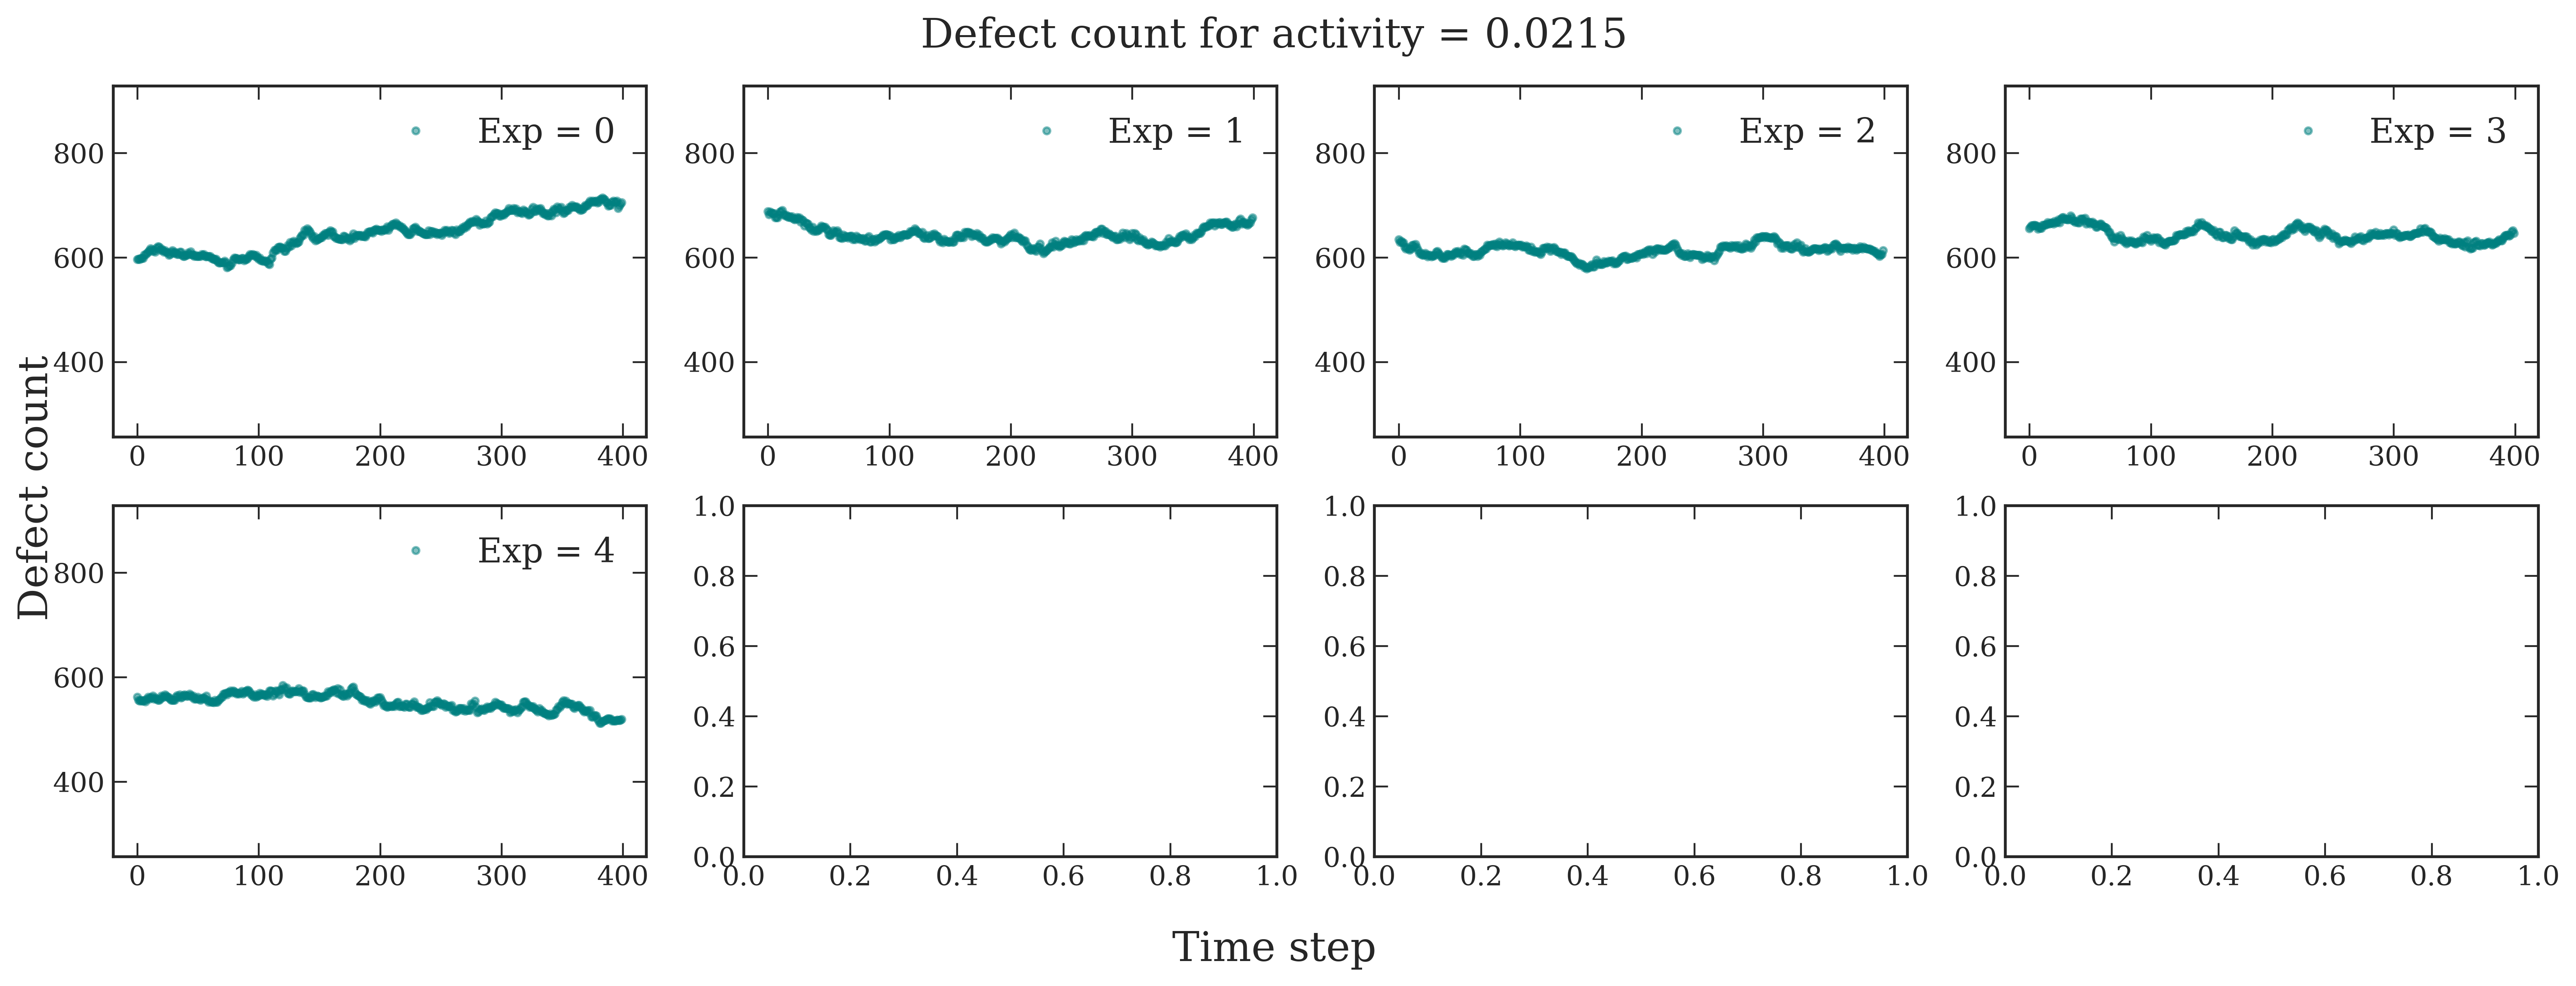

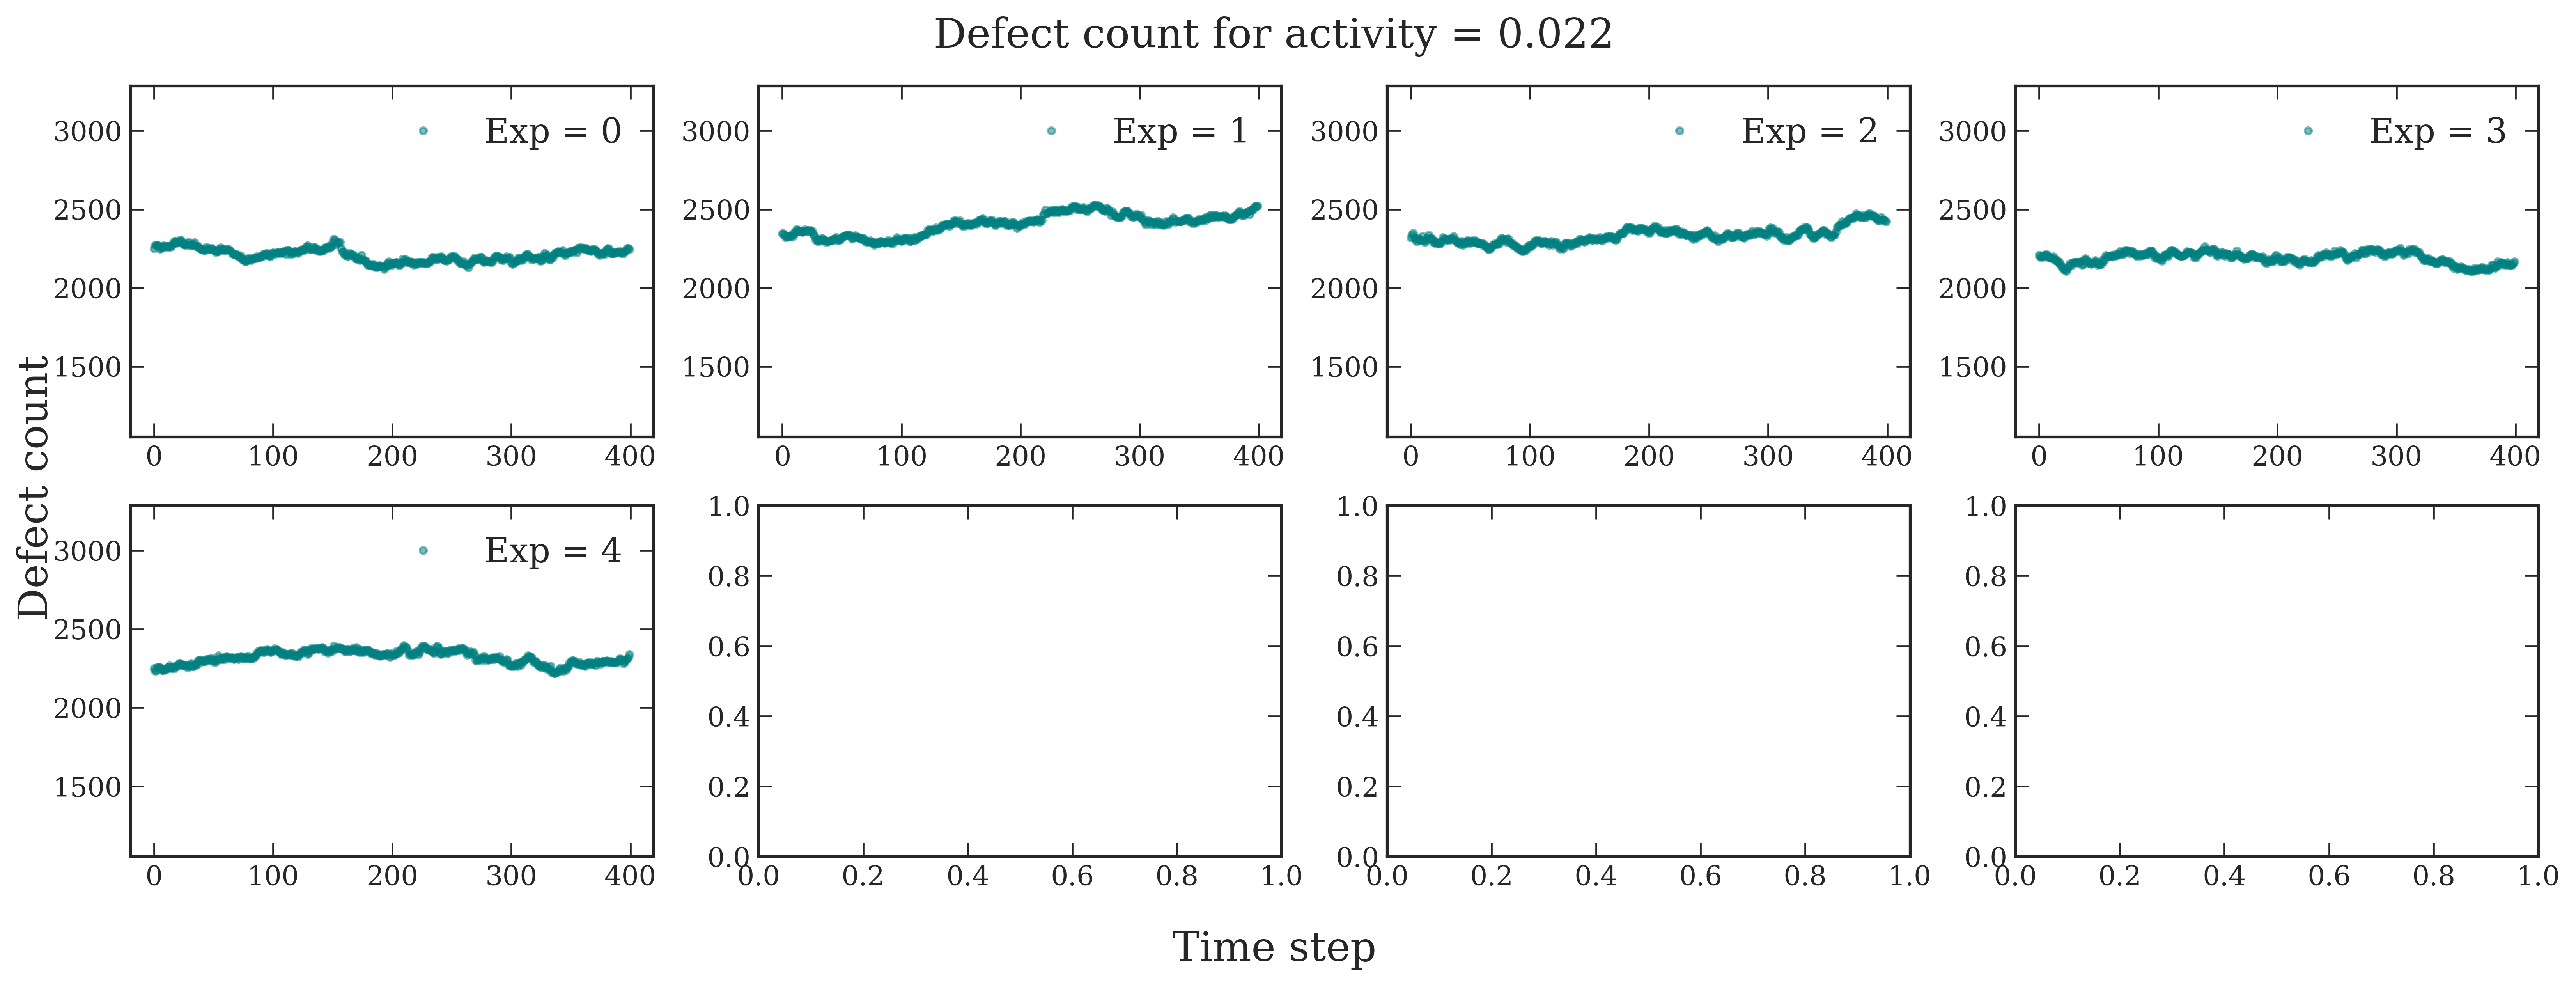

In [85]:
ad.plot_defects_per_exp(Ndataset=1)

In [5]:
if extract:
    ad.extract_results()
if analyze:
    ad.analyze_defects()
if merge:
    ad.merge_results()

In [ ]:
for Ndataset in range(ad.Ndata):
    ad.plot_defects_per_activity(Ndataset=Ndataset, save=True)
ad.plot_defects_per_activity(use_merged=True, save=True)

In [ ]:
fig, ax = ad.plot_alpha_mean(include=['sfac_av_unweighted', 'sfac_time_av_unweighted'], use_merged = True, save = True);
#ax.set_ylim(-1.3, .25)
ax.set_xlim(ad.act_list[0][0]-0.005, ad.act_list[0][-1]+.005)
ax.hlines(0, 0, 0.3, color='k', linestyle='-')   

In [ ]:
for Ndataset in range(ad.Ndata):
    ad.plot_hyperuniformity_sfac(Ndataset=Ndataset, weighted=False, save = True);

In [145]:
def plot_density_fluctuation_time_av(ad_object, Ndataset = 0, activity_list = [], act_idx_bounds = None, \
                                     window_idx_bounds = None, use_merged = False, save = False):
        
        LX = ad_object.LX[Ndataset]
        Ndataset = Ndataset if not use_merged else 0
        output_path = ad_object.output_path[Ndataset] if not use_merged else f'data\\nematic_analysis{LX}_LL0.05\\merged_results'
        custom_act_list = True if len(activity_list) > 0 else False
           
        if window_idx_bounds is None:
            window_idx_bounds = [0, len(ad_object.window_sizes[Ndataset])]
        if act_idx_bounds is None or custom_act_list:
            act_idx_bounds = [0, len(ad_object.act_list[Ndataset])]

        window_sizes = ad_object.window_sizes[Ndataset][window_idx_bounds[0]:window_idx_bounds[1]]
        act_list = ad_object.act_list[Ndataset][act_idx_bounds[0]:act_idx_bounds[1]]

        try:
            av_def = ad_object.get_arrays_av(Ndataset = Ndataset, use_merged = use_merged)[-1] / LX

            dens_fluc_av = ad_object.get_arrays_av(Ndataset = Ndataset, use_merged = use_merged)[-2][:, window_idx_bounds[0]:window_idx_bounds[1], act_idx_bounds[0]:act_idx_bounds[1]]
            
        except: 
            print('Density fluctuations not found. Analyse defects first.')
            return
        
       # dens_fluc_av *= av_def[:,0][None, None, :, None]

        min_vals = []

        fig, ax = plt.subplots(figsize=(8,6))
        for i, act in enumerate(act_list):
            if custom_act_list:
                if act not in activity_list:
                    continue

            act_idx = ad_object.act_list[Ndataset].index(act)

            dens_time_av = np.nanmean(dens_fluc_av[ad_object.conv_list[Ndataset][act_idx]:, :, i, 0], axis = 0)
            dens_time_std = np.nanstd(dens_fluc_av[ad_object.conv_list[Ndataset][act_idx]:, :, i, 0], axis = 0) \
                / np.sqrt(ad_object.Nframes[Ndataset] - ad_object.conv_list[Ndataset][act_idx])
            min_vals.append(dens_time_av[0])
            ax.errorbar(window_sizes, dens_time_av, dens_time_std, fmt='.', label = rf'$\zeta$ = {act}',\
                        capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 0.5, markersize=4)


        xticks = np.array([0.5, 1, 2.5, 5, 7.5, 10]) * ad_object.LX[Ndataset] / 100
        ax.set(xlabel = 'Window size / L ', ylabel = r'$\overline{\delta \rho ^2} ~/~ (\overline{\rho})^2$',\
               yscale = 'log', xscale = 'log', xticks = xticks, xticklabels = np.round(xticks / LX,3))
        ax.xaxis.set_minor_locator(ticker.NullLocator())
        ax.legend(fontsize = 12, ncol=3, loc = 'lower left')   
        fig.suptitle(rf'Time av. of $ \delta \rho^2$ vs window size (L = {LX})')
        fig.tight_layout()

        if save:
            if not os.path.isdir(os.path.join(output_path, 'figs')):
                os.makedirs(os.path.join(output_path, 'figs'))
            fig.savefig(os.path.join(output_path, f'figs\\dens_fluc_time_av.png'), dpi = 420, pad_inches=0.25)       
        return fig, ax, min_vals

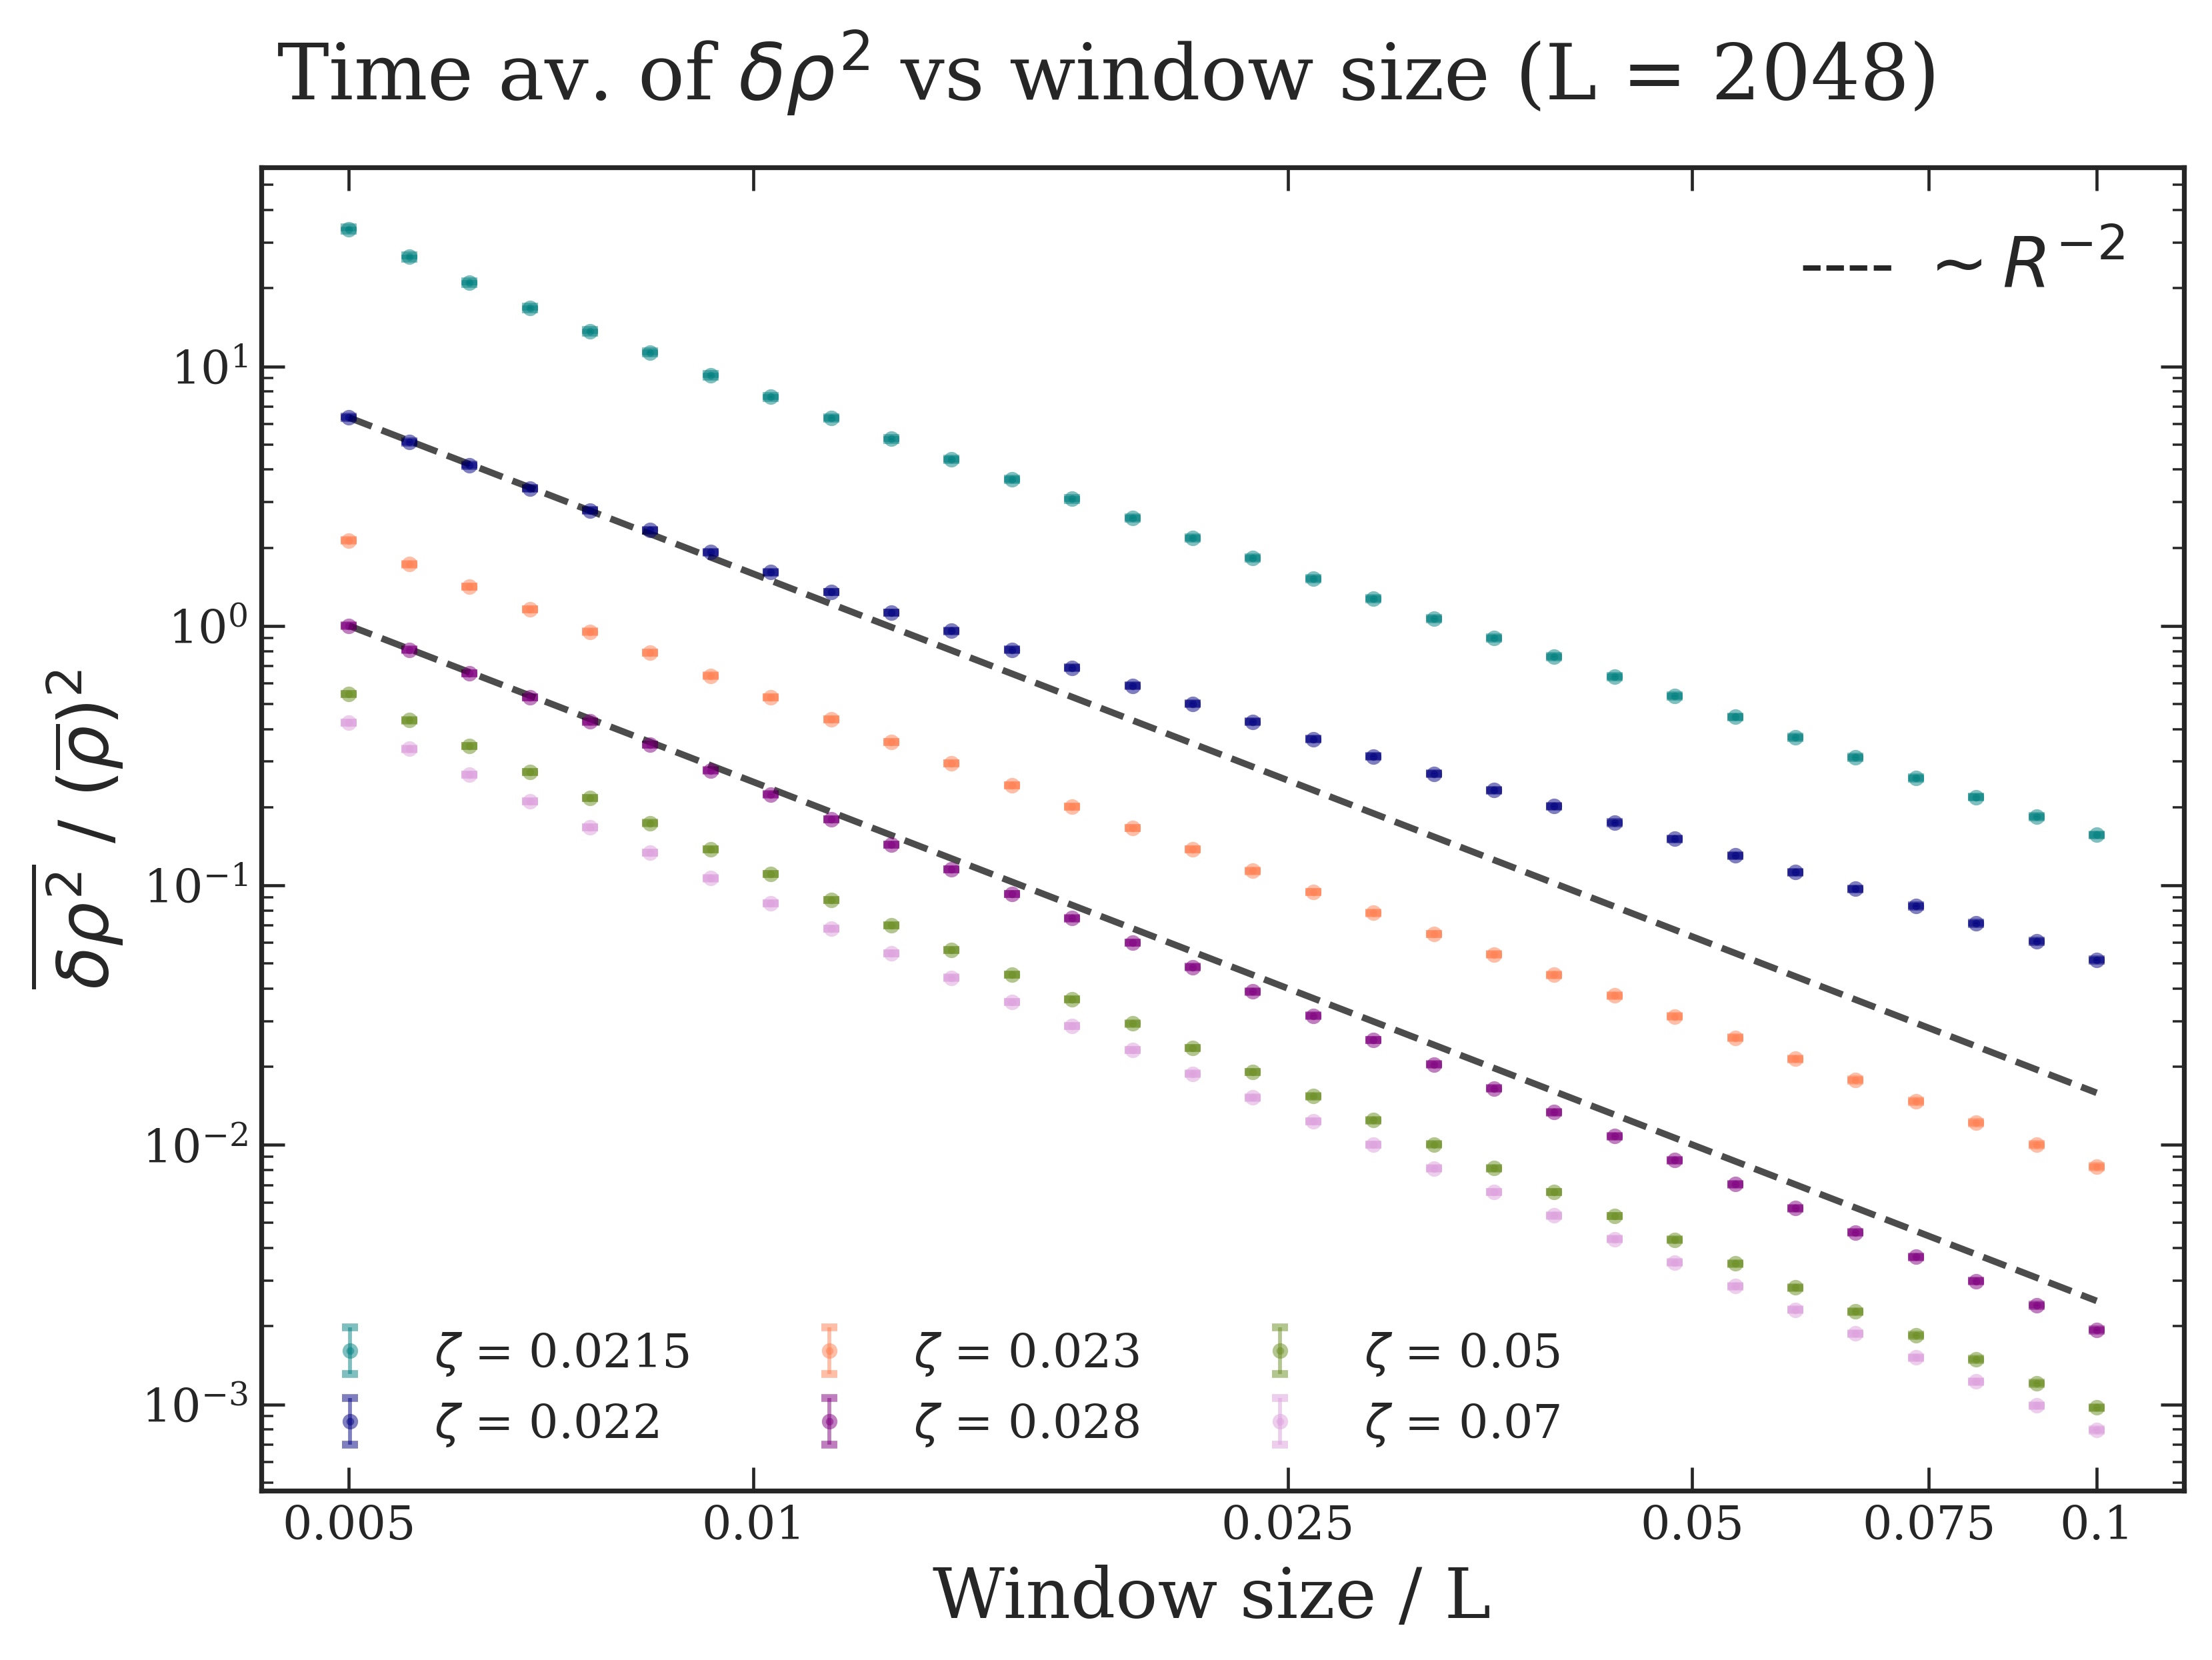

In [146]:
window_idx_bounds = [0, None]
act_idx_bounds = [4, -4]

acts_to_pop = [.024, .025, .026, 0.03, .032, 0.034, .04, .06]
acts_to_use = list(ad.act_list[0][act_idx_bounds[0]:act_idx_bounds[1]])
for act in acts_to_pop:
    acts_to_use.remove(act)
fig, ax, min_vals = plot_density_fluctuation_time_av(ad, activity_list=acts_to_use, act_idx_bounds = act_idx_bounds, \
                                           window_idx_bounds = window_idx_bounds, use_merged = True, save = True)

window_sizes = ad.window_sizes[0][window_idx_bounds[0]:window_idx_bounds[1]] #/ ad.LX[0]
min_val = 6

for i, val_idx in enumerate([1, 3]):
    val = min_vals[val_idx] 


    label = r'$\sim R^{-2}$' if i == 0 else None
    ax.plot(window_sizes, (val * window_sizes[0] ** 2) / window_sizes ** 2, \
            '--', color='black', alpha=0.7, lw = 1.7, label = label)


#ax.plot(window_sizes, (min_val * window_sizes[0] ** 2) / window_sizes ** 2, '--', color='black', alpha=0.7, lw = 1.7)
ax.text(0.8, 0.95, r'---- $\sim R^{-2}$', fontsize=18, transform=ax.transAxes, verticalalignment='top', fontweight='normal')
#ax.plot(window_sizes, (1 * window_sizes[0] ** 2) / window_sizes ** 2, '--', color='black', alpha=0.7, lw = 1.7)
#ax.plot(window_sizes, 13000/ window_sizes ** 3, '--', color='black', alpha=0.7, lw = 1.7)
#ax.text(0.15, 0.95, r'$\sim R^{-3}$', transform=ax.transAxes, fontsize=15, verticalalignment='top', fontweight='normal')
#ax.plot(window_sizes, (min_vals[1] * window_sizes[0] ** 2) / window_sizes ** 2, '--', color='black', alpha=0.7, lw = 1.7)
#ax.set_ylim(bottom = 7e-4, top = 40)
#ax.legend(ncol=2)
output_path = f'data\\nematic_analysis{LL}_LL0.05\\merged_results'
fig.savefig(os.path.join(output_path, f'figs\\dens_fluc_time_av.png'), dpi = 420, pad_inches=0.25)
